# Visualizing CNNs: Extras

Unfortunately it is not so easy to visualize filters from deeper layers because they are not in the input space and they depend on the filters preceeding them in the network. We can do something to see them, however.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.models import model_from_json
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print X_train.shape

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Load trained model- change paths as appropriate
model = model_from_json(open('../mnist_cnn.json').read())
model.load_weights('../mnist_cnn_weights.h5')
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


/Users/pumpikano/deeplearn2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


(60000, 1, 28, 28)


## Optimizing the input for visualization

When we feed an input to out model it produces activations in the feature maps. We want to understand what a particular filter deep in the network is "looking for". We can do this by **optimizing the input** to make this feature as strongly activated as possible. We will look for an input image that most strongly activates a give filter.

We can do this with gradient descent: rather than using gradient descent to change the weights of the network, we instead use gradient descent to change the input itself while keep the weights fixed. To do this, first we choose a filter in the network we wish to visualize and then define a loss function to encourage the filter to be strongly activated.

Below is a helper function to do this. Given a model, the layer index, and the filter index in that layer, it will return a function that evaluates a loss and the gradients for the input to maximize that loss (we are doing gradient ascent in this case). This loss can be a variety of things, but here it is the mean activation of the filter over all the locations in the image - the higher this value is, the more the input activates the filter. In this case we are using Keras's backend (Theano or Tensorflow) directly to compute these gradients.

In [10]:
def build_filter_iterator(model, layer, filter_ind):
    input_img = model.layers[0].input
    layer_output = model.layers[layer].output
    
    rank = len(model.layers[layer].output_shape)
    
    if rank == 4:
        # This is a convolutional layer, so average over locations
        loss = K.mean(layer_output[:, filter_ind, :, :])
    elif rank == 2:
        # This is a fully-connected layer
        loss = K.mean(layer_output[:, filter_ind])

    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # normalize the gradients (this is a trick that helps)
    return K.function([input_img, K.learning_phase()], [loss, grads])

Below we select the layer and filter. Then we generate a random image as a starting point and do 20 steps of gradient ascent to maximize the activation of the selected filter.

In [11]:
loss_fn = build_filter_iterator(model, 3, 0) # layer 3, filter 0

input_img_data = np.random.random((1, 1, 28, 28))
step = 0.1
for i in range(20):
    loss_value, grads_value = loss_fn([input_img_data, 0])
    input_img_data += grads_value * step

Now we can postprocess the image and display it:

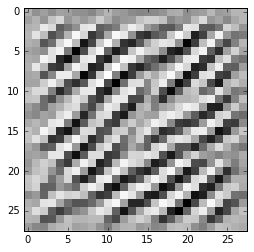

In [12]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

x = deprocess_image(input_img_data[0])
plt.imshow(np.squeeze(x), cmap='Greys', interpolation='none')

- - -
### Exercise 1 - interpretation

1. Experiment with different filters and different layers spatial layers (layers that are not fully-connected).
2. Try running the optimization for the same layer and filter multiple times - each run uses a different random starting point and could be different.
3. Many times the optimized image will looks like it has a repeating pattern. Can you explain why the procedure we are using would create images with repetition?
4. Compare some filters visualized in this way with the filter's feature maps. Can you see any correspondences?
- - -

#### Solutions
3. Since the filters are used convolutionally - i.e. we "slide" them over all the image - they don't really care where they are active, so they will try to be as active as possible everywhere. This is also a result of the loss function we are optimizing. Inside of `build_filter_iterator` the line `loss = K.mean(layer_output[:, filter_ind, :, :])` is taking the average activation of the given filter over all the input space. Maximizing this loss will lead to maximizing the filter activation in all locations in the image.
4. If you compare the filter's activation maps for real input data to the optimized input image for that filter, you should be able to see that visual motifs for which the filter is highly active in its feature map will be very similar to the visual motif that is replicated in the optimized input image generated here.

- - -
### Exercise 2  - optimize for deeper layers

We can visualize fully-connected layers deeper in the network with this technique as well. The `build_filter_iterator` method works on fully-connected layers as well. The only difference is that the loss function in this case does not average over spatial locations.

It is particularly interesting to try the layer right before the softmax layer. Each dimension in the layer is interpretable and corresponds to a class label.
- - -

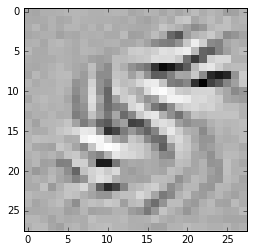

In [18]:
# Maximize activation for deep layers

loss_fn = build_filter_iterator(model, 10, 5)

input_img_data = np.random.random((1, 1, 28, 28))
step = 0.1
for i in range(20):
    loss_value, grads_value = loss_fn([input_img_data, 0])
    input_img_data += grads_value * step

x = deprocess_image(input_img_data[0])
plt.imshow(np.squeeze(x), cmap='Greys', interpolation='none')

- - -
### Exercise 3 - different loss

You can change the loss function defined inside `build_filter_iterator` to be anything you can imagine. Can you think of a different loss function to try? For example, you can try to maximize the activation of one unit while minimizing the activation of another. Or maximize one convolutional filter in a spatial region while minimizing another convolutional filter in another spatial region. The possibilities are endless.
- - -

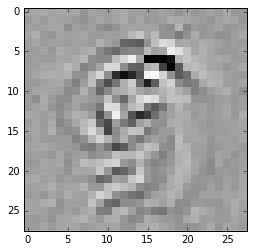

In [21]:
# Define a `build_filter_iterator2` function and use it to experiment with different forms for the loss function

def build_filter_iterator2(model, layer):
    input_img = model.layers[0].input
    layer_output = model.layers[layer].output
    
    rank = len(model.layers[layer].output_shape)
    
    if rank == 4:
        # This is a convolutional layer, so average over locations
        loss = K.mean(layer_output[:, filter_ind, :, :])
    elif rank == 2:
        # This is a fully-connected layer
        
        #######
        # Below is an example of maximizing the probability of 8 while minimizing the probability of 3
        loss = K.mean(layer_output[:, 8]) - K.mean(layer_output[:, 3])
        #######
        

    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # normalize the gradients (this is a trick that helps)
    return K.function([input_img, K.learning_phase()], [loss, grads])


loss_fn = build_filter_iterator2(model, 10)

input_img_data = np.random.random((1, 1, 28, 28))
step = 0.1
for i in range(20):
    loss_value, grads_value = loss_fn([input_img_data, 0])
    input_img_data += grads_value * step

x = deprocess_image(input_img_data[0])
plt.imshow(np.squeeze(x), cmap='Greys', interpolation='none')

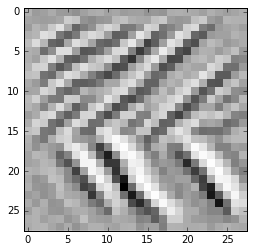

In [35]:
def build_filter_iterator3(model, layer):
    input_img = model.layers[0].input
    layer_output = model.layers[layer].output
    
    rank = len(model.layers[layer].output_shape)
    
    
    ########
    # This loss maximizes one filter in the top of the image and another in the bottom
    loss = K.mean(layer_output[:, 0, :14, :]) + K.mean(layer_output[:, 10, 14:, :])
    ########

    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # normalize the gradients (this is a trick that helps)
    return K.function([input_img, K.learning_phase()], [loss, grads])


loss_fn = build_filter_iterator3(model, 3)

input_img_data = np.random.random((1, 1, 28, 28))
step = 0.1
for i in range(20):
    loss_value, grads_value = loss_fn([input_img_data, 0])
    input_img_data += grads_value * step

x = deprocess_image(input_img_data[0])
plt.imshow(np.squeeze(x), cmap='Greys', interpolation='none')